# ADS 509 Assignment 5.1: Topic Modeling - Sarah Alqaysi

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')



In [79]:
# add any additional libaries you need here

import nltk
import os
import re
import emoji
import pandas as pd

from nltk.corpus import stopwords
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from sklearn.decomposition import TruncatedSVD

In [2]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [3]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [4]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [5]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


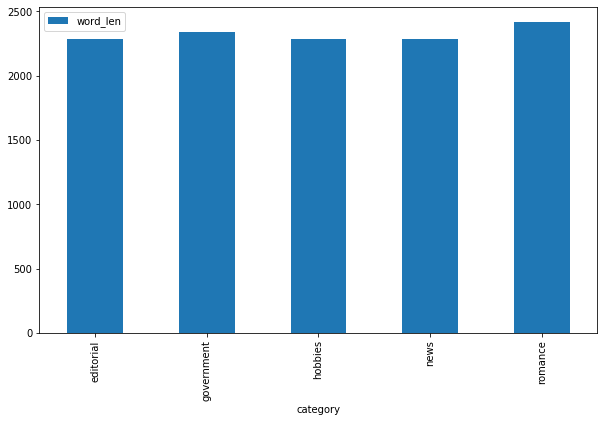

In [6]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [16]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\z003cu8m\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)


(166, 4941)

In [82]:
count_text_vectors

<166x4941 sparse matrix of type '<class 'numpy.int64'>'
	with 72541 stored elements in Compressed Sparse Row format>

In [8]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

In [81]:
tfidf_text_vectors

<166x4941 sparse matrix of type '<class 'numpy.float64'>'
	with 72541 stored elements in Compressed Sparse Row format>

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: They hold the frequency/inverse-frequency of the words in the datafamce, as well as the importance of the words.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [14]:
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.int` is a deprecated alias for the builtin `int`')

nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

C:\Users\z003cu8m\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [17]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

In [33]:
# clean the dataframe first 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
stop = stopwords.words('english')
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

In [46]:
# apply the `pipeline` techniques

#my_pipeline = [str.lower, remove_punctuation]

#df_new = df.apply(prepare,pipeline=my_pipeline)

df['text'] = df['text'].str.lower()

df["text"] = df['text'].apply(remove_punctuation)

# remove stopwords

df['text_clean'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

,category,id,text,char_len,word_len,text_clean
0,editorial,cb01,assembly session brought much good the general...,12659,2200,assembly session brought much good general ass...
1,editorial,cb02,must berlin remain divided the inference has...,12544,2234,must berlin remain divided inference widely ac...
2,editorial,cb03,a good man departs goodby mr sam sam raybur...,11871,2244,good man departs goodby mr sam sam rayburn goo...
3,editorial,cb04,a shock wave from africa word of dag hammarskj...,12284,2230,shock wave africa word dag hammarskjolds death...
4,editorial,cb05,help when needed if the dominican republic ach...,12479,2241,help needed dominican republic achieves free d...


In [49]:
# calling each category in a seperate dataframe

df_editorial=df.query("category == 'editorial'")
df_hobbies=df.query("category == 'hobbies'")
df_news=df.query("category == 'news'")
df_romance=df.query("category == 'romance'")
df_government=df.query("category == 'government'")

In [51]:
# adding the dataframes to lists

df_editorial_tokens = df_editorial['text_clean']
new_editorial_list = df_editorial_tokens.values.tolist()

df_hobbies_tokens = df_hobbies['text_clean']
new_hobbies_list = df_hobbies_tokens.values.tolist()

df_news_tokens = df_news['text_clean']
new_news_list = df_news_tokens.values.tolist()

df_romance_tokens = df_romance['text_clean']
new_romance_list = df_romance_tokens.values.tolist()

df_government_tokens = df_government['text_clean']
new_government_list = df_government_tokens.values.tolist()

In [73]:
# concatenating using join 

joined_ed = " ".join(ele for ele in new_editorial_list)
joined_hob = " ".join(ele for ele in new_hobbies_list)
joined_nws = " ".join(ele for ele in new_news_list)
joined_ro = " ".join(ele for ele in new_romance_list)
joined_gov = " ".join(ele for ele in new_government_list)

# mapping using Counter()
mappd_ed = Counter(joined_ed.split())
  
# getting total using sum 
total_val_ed = sum(mappd_ed.values())
  
# getting share of each word
res_ed = {key: val / total_val_ed for key,
       val in mappd_ed.items()}

# mapping using Counter()
mappd_nws = Counter(joined_nws.split())
  
# getting total using sum 
total_val_nws = sum(mappd_nws.values())
  
# getting share of each word
res_nws = {key: val / total_val_nws for key,
       val in mappd_nws.items()}

# mapping using Counter()
mappd_ro = Counter(joined_ro.split())
  
# getting total using sum 
total_val_ro = sum(mappd_ro.values())
  
# getting share of each word
res_ro = {key: val / total_val_ro for key,
       val in mappd_ro.items()}

# mapping using Counter()
mappd_hob = Counter(joined_hob.split())
  
# getting total using sum 
total_val_hob = sum(mappd_hob.values())
  
# getting share of each word
res_hob = {key: val / total_val_hob for key,
       val in mappd_hob.items()}

# mapping using Counter()
mappd_gov = Counter(joined_gov.split())
  
# getting total using sum 
total_val_gov = sum(mappd_gov.values())
  
# getting share of each word
res_gov = {key: val / total_val_gov for key,
       val in mappd_gov.items()}

# printing result
#print("Percentage share of each word : " + str(res))

df_new_editorial_list = pd.DataFrame.from_dict(res_ed, orient="index").reset_index()
df_new_editorial_list.columns = ['editorial_top_words', 'editorial_ratio']
df_new_editorial_list.sort_values(by='editorial_ratio', ascending=False).head(5)

df_new_hobbies_list = pd.DataFrame.from_dict(res_hob, orient="index").reset_index()
df_new_hobbies_list.columns = ['hobbies_top_words', 'hobbies_ratio']
df_new_hobbies_list.sort_values(by='hobbies_ratio', ascending=False).head(5)

df_new_news_list = pd.DataFrame.from_dict(res_nws, orient="index").reset_index()
df_new_news_list.columns = ['news_top_words', 'news_ratio']
df_new_news_list.sort_values(by='news_ratio', ascending=False).head(5)

df_new_romance_list = pd.DataFrame.from_dict(res_ro, orient="index").reset_index()
df_new_romance_list.columns = ['romance_top_words', 'romance_ratio']
df_new_romance_list.sort_values(by='romance_ratio', ascending=False).head(5)

df_new_government_list = pd.DataFrame.from_dict(res_gov, orient="index").reset_index()
df_new_government_list.columns = ['government_top_words', 'government_ratio']
df_new_government_list.sort_values(by='government_ratio', ascending=False).head(5)

,government_top_words,government_ratio
872,states,0.005885
1135,state,0.005626
61,year,0.005253
178,may,0.005138
871,united,0.004449


In [74]:
# top words in "romance" category

df_new_romance_list.sort_values(by='romance_ratio', ascending=False).head(5)

,romance_top_words,romance_ratio
139,said,0.011305
24,would,0.008436
5,could,0.006660
355,like,0.006455
64,one,0.006216


In [78]:
# top words in "news" category

df_new_news_list.sort_values(by='news_ratio', ascending=False).head(5)

,news_top_words,news_ratio
4,said,0.007855
285,mrs,0.004914
336,would,0.004760
206,new,0.004663
137,one,0.004121


In [76]:
# top words in "hobbies" category

df_new_hobbies_list.sort_values(by='hobbies_ratio', ascending=False).head(5)

,hobbies_top_words,hobbies_ratio
44,one,0.007090
53,new,0.003694
841,may,0.003545
29,time,0.003297
264,first,0.003124


In [77]:
# top words in "editorial" category

df_new_editorial_list.sort_values(by='editorial_ratio', ascending=False).head(5)

,editorial_top_words,editorial_ratio
246,would,0.006333
196,one,0.005922
385,new,0.004587
1191,mr,0.003766
135,us,0.003047


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: There are some common words between the two, however, the ratio is a little different.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

In [80]:
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.int` is a deprecated alias for the builtin `int`')

svd_text_model = TruncatedSVD(n_components = 10, random_state=42)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: I see more common words on the LSA model compared to the original corpus as more topics are printed.

In [21]:
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.06)
  kennedy (0.82)
  laos (0.78)

Topic 03
  mrs (29.99)
  club (6.67)
  game (6.21)
  jr (5.71)
  dallas (5.47)

Topic 04
  game (4.46)
  league (3.20)
  baseball (3.18)
  ball (3.02)
  team (2.91)

Topic 05
  mrs (4.51)
  music (1.15)
  af (1.09)
  khrushchev (1.04)
  miss (0.98)

Topic 06
  faculty (184.24)
  college (178.80)
  student (139.55)
  shall (123.17)
  university (114.98)

Topic 07
  mrs (10.11)
  sales (5.92)
  marketing (4.33)
  billion (4.33)
  business (4.01)

Topic 08
  state (26.37)
  states (18.26)
  united (16.73)
  shall (15.81)
  mrs (15.67)

Topic 09
  shall (19.61)
  united (17.02)
  board (14.47)
  states (11.02)
  court (10.58)


Q: What is your interpretation of the display topics output? 

A: The svd model has the highest relevance on it's topics.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [22]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\z003cu8m\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)


(166, 4941)

In [23]:
lda_text_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [25]:
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  clay (0.54)
  game (0.47)
  place (0.45)
  cut (0.45)
  home (0.44)

Topic 01
  pool (0.77)
  use (0.71)
  national (0.70)
  area (0.57)
  good (0.56)

Topic 02
  million (0.60)
  military (0.57)
  sales (0.54)
  aircraft (0.54)
  equipment (0.50)

Topic 03
  feed (3.04)
  said (1.47)
  head (1.08)
  meeting (0.94)
  daily (0.91)

Topic 04
  said (1.83)
  sam (0.67)
  eyes (0.63)
  thought (0.63)
  little (0.58)

Topic 05
  mrs (1.05)
  said (0.88)
  old (0.67)
  mr (0.56)
  man (0.56)

Topic 06
  said (2.73)
  board (0.85)
  000 (0.66)
  court (0.56)
  county (0.55)

Topic 07
  state (1.08)
  medical (0.75)
  shelter (0.68)
  program (0.53)
  service (0.53)

Topic 08
  state (0.85)
  united (0.78)
  states (0.72)
  government (0.70)
  president (0.67)

Topic 09
  fiscal (1.00)
  property (0.86)
  island (0.69)
  tax (0.69)
  state (0.61)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The LDA model shows good reults on the feature relevance, however not as strong as the svd model.


Q: How does your five-topic LDA model compare to the original Brown categories? 

A: The later topics have more common words with the original categories.

In [26]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

C:\Users\z003cu8m\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [27]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: We can see from the scatter plot what has been confirming the results of our models compared to the original Brown categories. The more advanced are the topics, 07 & 09, the more common features we get bwtween the two sets. The graph shows that topic 09 has the most similar relevant and similar features between the models and the original categories.